In [2]:
# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


import pandas as pd
from time import time


import numpy as np
np.set_printoptions(suppress=True)
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import config as cfg
from common import DataParser

from LinearRegression import LinearRegression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
plt.style.use('seaborn')

In [3]:
data, labels = DataParser.parse_moneyball(splitData=True)

In [4]:
cols_to_drop = ['Team', 'League', 'Year', 'RankSeason', 'RankPlayoffs', 'Playoffs']
df_prep = data.drop(cols_to_drop, axis=1)

# Fix missing values and type
df_prep.replace("?",0, inplace=True)
#df_prep = df_prep[df_prep.OOBP != 0]
df_prep[['OOBP','OSLG']] = df_prep[['OOBP','OSLG']].astype(float)

In [5]:
df = df_prep.dropna()
df

,RS,RA,W,OBP,SLG,BA,G,OOBP,OSLG
0,734,688,81,0.328,0.418,0.259,162,0.317,0.415
1,700,600,94,0.320,0.389,0.247,162,0.306,0.378
2,712,705,93,0.311,0.417,0.247,162,0.315,0.403
3,734,806,69,0.315,0.415,0.260,162,0.331,0.428
4,613,759,61,0.302,0.378,0.240,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...
415,872,831,86,0.356,0.434,0.271,162,0.345,0.423
416,809,838,75,0.338,0.426,0.262,161,0.355,0.427
417,772,913,69,0.343,0.411,0.274,162,0.371,0.448
418,945,859,95,0.361,0.479,0.293,162,0.346,0.459


In [6]:
labels = pd.DataFrame(df["W"]).to_numpy()
data = pd.DataFrame(df.drop("W", axis=1)).to_numpy()

#scaler = Normalizer()
scaler = MinMaxScaler((-1,1))
scaler.fit(data)
data = scaler.transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1 )

y_train = y_train.T[0]
y_test = y_test.T[0]

In [7]:
def benchmarkRegressor(reg, name):
    start_time = time()
    reg.fit(X_train,y_train)
    end_time = time()
    fit_time = end_time - start_time

    y_pred = reg.predict(X_test)


    print(f"R2 for {name}: {r2_score(y_test, y_pred)}, fit-time = {fit_time}")

alpha=0.0001
max_iter = 10000

sk_reg = SGDRegressor(alpha=alpha, max_iter=max_iter)
sk_lin = SK_LinearRegression()
ML2020_uniform = LinearRegression(alpha=alpha, max_iter=max_iter)
ML2020_residual = LinearRegression(alpha=alpha, max_iter=max_iter)

benchmarkRegressor(sk_reg, "SK SDG Regressor")
benchmarkRegressor(sk_lin, "SK Linear Regressor")
benchmarkRegressor(ML2020_uniform, "ML2020")

R2 for SK SDG Regressor: 0.8901556855029208, fit-time = 0.009997129440307617
R2 for SK Linear Regressor: 0.8943991725099895, fit-time = 0.0029990673065185547
R2 for ML2020: 0.8920666989279775, fit-time = 0.12099814414978027


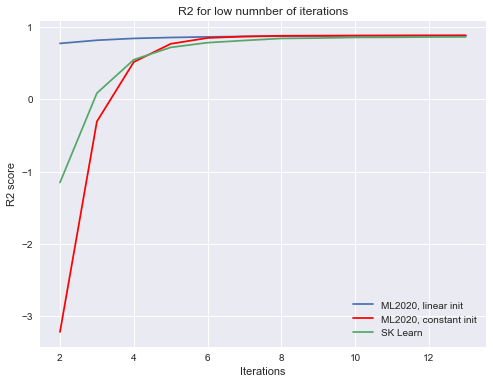

In [13]:
iter_vals = list(range(2,14,1))
alpha = 0.02 
plt.figure(figsize=(8,6))


plt.plot(iter_vals,[r2_score(y_test, LinearRegression(alpha=alpha, max_iter=max_iter, init_mode="linear").fit(X_train,y_train).predict(X_test)) for max_iter in iter_vals], label="ML2020, linear init")
plt.plot(iter_vals,[r2_score(y_test, LinearRegression(alpha=alpha, max_iter=max_iter,  init_mode="constant").fit(X_train,y_train).predict(X_test)) for max_iter in iter_vals], label="ML2020, constant init", color="r")
plt.plot(iter_vals,[r2_score(y_test, SGDRegressor(alpha=alpha, max_iter=max_iter).fit(X_train,y_train).predict(X_test)) for max_iter in iter_vals], label="SK Learn")


plt.legend()
#plt.grid()
plt.title("R2 for low numnber of iterations")
plt.xlabel("Iterations")
plt.ylabel("R2 score")

plt.savefig("out/init_comparison")
plt.show()

